### Caso 2

Amalia Cabonell - 202122079 \
Santiago Arenas - 202220359 \
Santiago Casasbuenas - 202214932

In [15]:
from pyomo.environ import *
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from geopy.geocoders import Nominatim


# CARGA DE DATOS

clients_df = pd.read_csv('data_cases/caso_2/clients.csv')
depots_df = pd.read_csv('data_cases/caso_2/depots.csv')
stations_df = pd.read_csv('data_cases/caso_2/stations.csv')
vehicles_df = pd.read_csv('data_cases/caso_2/vehicles.csv')

# Coordenadas manuales de clientes sacados del archivo de caso base 
coords={}

geolocator = Nominatim(user_agent="myGeocoder", timeout=10)

for index, row in clients_df.dropna(subset=['City/Municipality']).iterrows():
    client_id = row['LocationID']
    ciudad = row['City/Municipality']
    
    try:
        ubicacion = geolocator.geocode(f"{ciudad}, Colombia")
        if ubicacion:
            coords[client_id] = (float(ubicacion.longitude), float(ubicacion.latitude))
        else:
            coords[client_id] = None
    except Exception as e:
        print(f"Error con el cliente {client_id} ({ciudad}): {e}")
        coords[client_id] = None


# Depósito
for _, row in depots_df.iterrows():
    coords[int(row['DepotID'])] = (row['Longitude'], row['Latitude'])

# Estaciones (ID + 100 para poder diferenciarlas)
stations_df['NewID'] = stations_df['EstationID'] + 100

for _, row in stations_df.iterrows():
    coords[int(row['NewID'])] = (float(row['Longitude']), float(row['Latitude']))

clientes = clients_df['LocationID'].tolist()
deposito = depots_df['DepotID'].tolist()[0]
estaciones = stations_df['NewID'].tolist()
vehiculos = vehicles_df['VehicleID'].tolist()

nodos = [deposito] + clientes + estaciones
n = len(nodos)

print(coords)
print(clients_df[clients_df['ClientID'] == 15])

# PARÁMETROS

demanda = dict(zip(clients_df['LocationID'], clients_df['Demand']))
capacidad = dict(zip(vehicles_df['VehicleID'], vehicles_df['Capacity']))
autonomia = dict(zip(vehicles_df['VehicleID'], vehicles_df['Range']))
precio_combustible = dict(zip(stations_df['NewID'], stations_df['FuelCost']))
consumo_km = 0.25  # litros por km

id_to_idx = {nodo: i for i, nodo in enumerate(nodos)}
idx_to_id = {i: nodo for nodo, i in id_to_idx.items()}

def haversine(coord1, coord2):
    R = 6371
    lon1, lat1 = map(radians, coord1)
    lon2, lat2 = map(radians, coord2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

cost_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            cost_matrix[i][j] = haversine(coords[nodos[i]], coords[nodos[j]])


{2: (-74.0720857, 4.7110053), 3: (-75.6025597, 6.2697324), 4: (-76.5325259, 3.4519988), 5: (-75.5441671, 10.4265566), 6: (-72.4689002, 8.0776187), 7: (-73.1047294, 7.1669842), 8: (-75.788322, 4.7854606), 9: (-74.1950916, 11.2320944), 10: (-75.2108857, 4.4386033), 11: (-75.5081167, 5.0743694), 12: (-75.2794303, 3.0332554), 13: (-74.8231794, 11.0101922), 14: (-73.4967836, 4.1114594), 15: (-75.7413509, 4.4919761), 1: (-74.796387, 10.963889), 101: (-74.796387, 10.963889), 102: (-75.51444, 10.39972), 103: (-74.19904, 11.24079), 104: (-73.1198, 7.12539), 105: (-74.063644, 4.624335), 106: (-75.590553, 6.230833), 107: (-76.522224, 3.420556), 108: (-74.4300155, 7.794112), 109: (-75.19347, 8.597361), 110: (-76.0563885, 4.8256945), 111: (-75.292934, 4.0224455), 112: (-73.2, 5.8)}
Empty DataFrame
Columns: [ClientID, City/Municipality, Demand, LocationID]
Index: []


In [16]:

# MODELO PYOMO

model = ConcreteModel()
model.N = RangeSet(0, n - 1)
model.K = RangeSet(1, len(vehiculos))

model.x = Var(model.N, model.N, model.K, within=Binary)
model.u = Var(model.N, model.K, within=NonNegativeReals)

model.fuel = Var(model.N, model.K, domain=NonNegativeReals)
model.refuel = Var(model.N, model.K, domain=NonNegativeReals)

for k in model.K:
    model.fuel[0, k].fix(autonomia[k])

# Objetivo: minimizar distancia y costo de gasolina 


model.obj = Objective(
    expr=sum(
        cost_matrix[i][j] * model.x[i, j, k]
        for i in model.N for j in model.N for k in model.K if i != j
    ) +
    sum(
        precio_combustible.get(idx_to_id[i], 0) * model.refuel[i, k]
        for i in model.N for k in model.K
    ),
    sense=minimize
)


# Restricciones

# Se asegura que un camión salga una vez del depósito y regrese una vez
model.deposito = ConstraintList()
for k in model.K:
    model.deposito.add(sum(model.x[0, j, k] for j in model.N if j != 0) == 1)
    model.deposito.add(sum(model.x[j, 0, k] for j in model.N if j != 0) == 1)

#Asegura conservación de flujo: si un camión entra a un nodo, también debe salir. ( no teletransporte)
model.flujo = ConstraintList()
for k in model.K:
    for i in model.N:
        if i != 0:
            model.flujo.add(
                sum(model.x[i, j, k] for j in model.N if i != j) ==
                sum(model.x[j, i, k] for j in model.N if i != j)
            )

# Evita los ciclos 
model.subtour = ConstraintList()
for k in model.K:
    for i in model.N:
        for j in model.N:
            if i != j and i != 0 and j != 0:
                model.subtour.add(
                    model.u[i, k] - model.u[j, k] + n * model.x[i, j, k] <= n - 1
                )

# Cada cliente debe ser visitado 
model.visita = ConstraintList()
for i in model.N:
    if i != 0:
        model.visita.add(
            sum(model.x[i, j, k] for j in model.N for k in model.K if i != j) == 1
       )

#Asegura que la demanda total que lleva cada camión no supere su capacidad máxima de carga
model.capacidad_total = ConstraintList()
for k in model.K:
    model.capacidad_total.add(
        sum(
            demanda.get(idx_to_id[i], 0) * sum(model.x[i, j, k] for j in model.N if i != j)
            for i in model.N
        ) <= capacidad[k]
    )

# Restricciones Gasolina 

# Simula la dinámica del combustible: debo tener suficiente para ir de tal a tal 
model.restriccion_combustible = ConstraintList()
for k in model.K:
    for i in model.N:
        for j in model.N:
            if i != j:
                distancia = cost_matrix[i][j]
                model.restriccion_combustible.add(
                    model.fuel[j, k] <= model.fuel[i, k] - consumo_km * distancia * model.x[i, j, k] + model.refuel[j, k]
                )

# Combustible nunca puede superar el tanque
model.limite_tanque = ConstraintList()
for k in model.K:
    for i in model.N:
        model.limite_tanque.add(model.fuel[i, k] <= autonomia[k])



# SOLVER

solver = SolverFactory("glpk")
solver.options["tmlim"] = 60
solver.solve(model)


# IMPRIMIR RUTAS

routes = {k: [] for k in model.K}
for k in model.K:
    actual = 0
    visitados = set()
    while True:
        next_node = None
        for j in model.N:
            if j != actual and model.x[actual, j, k].value is not None and model.x[actual, j, k].value > 0.5:
                next_node = j
                break
        if next_node is None or next_node in visitados:
            break
        routes[k].append(next_node)
        visitados.add(next_node)
        actual = next_node

for k, ruta in routes.items():
    traducida = [idx_to_id[i] for i in [0] + ruta + [0]]
    print(f"Camión {k}: {' → '.join(map(str, traducida))}")

Camión 1: 1 → 106 → 15 → 10 → 11 → 12 → 111 → 8 → 110 → 4 → 107 → 1 → 1
Camión 2: 1 → 108 → 3 → 104 → 6 → 7 → 1 → 1
Camión 3: 1 → 9 → 103 → 13 → 101 → 1 → 1
Camión 4: 1 → 112 → 14 → 105 → 2 → 109 → 1 → 1
Camión 5: 1 → 5 → 102 → 1 → 1


In [2]:
print("\nDistancia recorrida por cada camión:")
distancias = {}
for k in model.K:
    distancia = 0
    for i in model.N:
        for j in model.N:
            if i != j and model.x[i, j, k].value is not None and model.x[i, j, k].value > 0.5:
                distancia += cost_matrix[i][j]
    distancias[k] = distancia
    print(f"Camión {k}: {round(distancia, 2)} km")

print(f"\nDistancia total recorrida: {round(sum(distancias.values()), 2)} km")


Distancia recorrida por cada camión:
Camión 1: 1485.04 km
Camión 2: 2076.51 km
Camión 3: 2125.77 km
Camión 4: 2448.01 km
Camión 5: 0.0 km

Distancia total recorrida: 8135.33 km


In [17]:
import matplotlib.pyplot as plt
import random

def graficar_rutas_pyomo(routes, idx_to_id, coords):
    plt.figure(figsize=(10, 10))
    plt.title("Rutas por Vehículo")

    # Dibujar nodos
    for nodo, (lon, lat) in coords.items():
        es_deposito = nodo == 1
        es_estacion = nodo >= 100
        color = 'ko' if es_deposito else ('go' if es_estacion else 'bo')
        plt.plot(lon, lat, color)
        plt.text(lon + 0.003, lat + 0.003, str(nodo), fontsize=9)

    # Dibujar rutas
    for k, ruta in routes.items():
        ruta_completa = [0] + ruta + [0]  # índice interno
        color = "#" + ''.join(random.choices('0123456789ABCDEF', k=6))
        for i in range(len(ruta_completa) - 1):
            origen = idx_to_id[ruta_completa[i]]
            destino = idx_to_id[ruta_completa[i+1]]
            x1, y1 = coords[origen]
            x2, y2 = coords[destino]
            plt.plot([x1, x2], [y1, y2], color=color, linewidth=2)

    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True)
    plt.show()



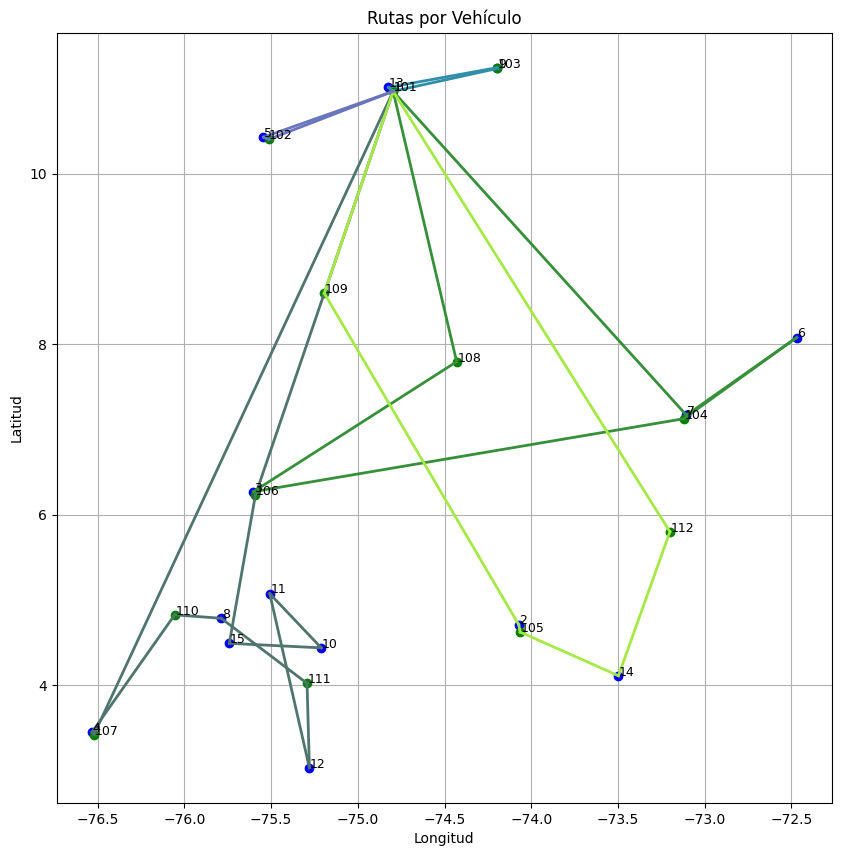

In [18]:
graficar_rutas_pyomo(routes, idx_to_id, coords)


In [19]:
%pip install folium

Note: you may need to restart the kernel to use updated packages.


In [20]:
import folium
from folium import Map, Marker, PolyLine
import random

def graficar_rutas_en_folium(routes, idx_to_id, coords):
    # Crear mapa centrado en Bogotá
    mapa = folium.Map(location=[4.65, -74.1], zoom_start=11)

    # Colores para cada camión
    colores = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'black']

    # Marcar todos los nodos
    for nodo_id, (lon, lat) in coords.items():
        tipo = 'Depósito' if nodo_id == 1 else ('Estación' if nodo_id >= 100 else 'Cliente')
        color = 'black' if tipo == 'Depósito' else ('green' if tipo == 'Estación' else 'blue')
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.9,
            popup=f"{tipo} {nodo_id}"
        ).add_to(mapa)

    # Dibujar rutas por camión
   # Dibujar rutas por camión
    for k, ruta in routes.items():
        ruta_completa = [0] + ruta + [0]  # índice → empieza y termina en depósito
        puntos = []
        for i in range(len(ruta_completa) - 1):
            origen = idx_to_id[ruta_completa[i]]
            destino = idx_to_id[ruta_completa[i + 1]]
            lon1, lat1 = coords[origen]  # ✔️ Aquí corregimos el orden
            lon2, lat2 = coords[destino]
            puntos.append([[lat1, lon1], [lat2, lon2]])  # ✔️ folium requiere [lat, lon]
        color = colores[(k - 1) % len(colores)]
        for segmento in puntos:
            folium.PolyLine(locations=segmento, color=color, weight=4, opacity=0.8,
                            popup=f"Camión {k}").add_to(mapa)


    return mapa


In [21]:
mapa = graficar_rutas_en_folium(routes, idx_to_id, coords)
mapa


### Conclusiones 

**- Ubicación no estratégica de estaciones de recarga**
    El modelo incorpora restricciones realistas sobre autonomía de los vehículos y necesidad de recargar en estaciones. Sin embargo, las estaciones de recarga disponibles están ubicadas muy lejos de las rutas naturales que deben seguir los vehículos para atender a los clientes. Por esta razon los vehiculos se deben desviar de manera ineficiente para recargar y visitar las estaciones. 

**-Visualización de rutas y recargas**
    Las graficas mostradas mas arriba nos muestran los caminos que seguirian los camiones para cumplir con las rutas. Vemos como muchos trayectos terminan incluyendo visitas forzadas a múltiples estaciones, incluso encadenadas una tras otra, lo cual no es representativo de una operación eficiente.

**- Obligatoriedad de las estaciones** 
    Un error en nuestro modelo que no logramos solucionar fue no volver obligatoria la visita a las estaciones de servicio. Si estas estaciones se ponian opcionales los camiones no salian del deposito o no detectaban cuando debian parar por gasolina. Por esta razon, todas los clientes , estacioens y deposito son visitados en nuestro caso. 

